In [1]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
dataset_path = '~/datasets'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, train=True, download=True)
test_dataset  = MNIST(dataset_path, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



### Model

In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, hidden_dim: int = 256, latent_dim: int = 16):
        super(Encoder, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        #input: Nx1x28
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1) #Nx32x14x14 
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) #Nx64x7x7
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1) #Nx128x4x4

        self.hidden = nn.Linear(4*4*128, hidden_dim)
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.sigma = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        h = F.leaky_relu(self.conv1(x))
        h = F.leaky_relu(self.conv2(h))
        h = F.leaky_relu(self.conv3(h))
        h = F.leaky_relu(self.hidden(h.view(-1, 4*4*128)))
        mu = self.mu(h)
        log_sigma = self.sigma(h)

        z = self.reparameterization(mu, log_sigma)

        return z, (mu, log_sigma)
    
    def reparameterization(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        epsilon = torch.randn_like(sigma).to(self.device)
        z = mu + sigma * epsilon
        
        return z

In [4]:
class VAE(nn.Module):
    def __init__(self, decoder, hidden_dim: int = 256, latent_dim: int = 16):
        super(VAE, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.latent_dim = latent_dim
        self.encoder = Encoder(hidden_dim = hidden_dim, latent_dim = latent_dim).to(self.device)
        self.decoder = decoder.to(self.device)

    def forward(self, x):
        z, (mu, log_sigma) = self.encoder(x)
        return self.decoder(z), mu, log_sigma


### Early Stopping 

In [32]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0

    def __call__(self, validation_loss, previous_validation_loss):
        if validation_loss >= previous_validation_loss:
            self.counter+=1
        elif np.abs(previous_validation_loss - validation_loss) < self.min_delta:
            self.counter+=1
        elif previous_validation_loss - validation_loss >= self.min_delta:
            self.counter=0
            previous_validation_loss = validation_loss

        if self.counter > self.patience:
            return True
        else:
            return False

# 2b.Training and Testing of Beta Distribution

\begin{align}
    \log p(\textbf{x}|\textbf{z}) &= - \log \prod_{d=1}^D p(X_d|\textbf{z}) \\ 
    &= \sum_{d=1}^D log(Bate(X_d|\alpha_d(\textbf{z}), \beta_d(\textbf{z})))
\\
    &= \sum_{d=1}^D log(\frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}x_d^{\alpha-1}(1-x_d)^{\beta-1})
\\
    &= \sum_{d=1}^D log(\Gamma(\alpha+\beta))-log(\Gamma(\alpha))-log(\Gamma(\beta))+log(x_d^{\alpha-1}(1-x_d)^{\beta-1})
\end{align}

When x = 0 or x = 1, the last log term may become undefined since log0 or $\frac{1}{0}$. so we add a $\epsilon = 1$ to this term to prevent this problem, then the whole formula become:

$$
\sum_{d=1}^D log(\Gamma(\alpha+\beta))-log(\Gamma(\alpha))-log(\Gamma(\beta))+log((x_d + \epsilon)^{\alpha-1}(1-x_d + \epsilon)^{\beta-1})
$$

In [47]:
class Beta_Decoder(nn.Module):
    def __init__(self, latent_dim: int = 16):
        super(Beta_Decoder, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.FC = nn.Linear(latent_dim, 3*3*128)
        # input: Nx128x3x3
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1) #Nx64x6x6
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=0, output_padding =1) #Nx32x14x14
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding = 1) #Nx1x28x28
        
        self.alpha = nn.Linear(28*28, 28*28)
        self.beta = nn.Linear(28*28, 28*28)
        # sigma is omitted as we consider variance being fixed

    def forward(self, x):
        h = F.leaky_relu(self.FC(x)).view(-1, 128, 3, 3)
        h = F.leaky_relu(self.deconv1(h))
        h = F.leaky_relu(self.deconv2(h))
        h = F.leaky_relu(self.deconv3(h))
        alpha = F.sigmoid(self.alpha(h.view(-1, 28*28)))
        beta = F.sigmoid(self.beta(h.view(-1, 28*28)))

        return alpha, beta

In [48]:
def loss_function(x, alpha, beta, mu, log_sigma, epsilon = 1e-8):
      # Log-likelihood for beta distribution
      term_1 = (x + epsilon).pow(alpha-1)
      term_2 = (1-x + epsilon).pow(beta-1)
      log_p = torch.sum(torch.lgamma(alpha+beta) + torch.log(term_1) + torch.log(term_2) - torch.lgamma(alpha) - torch.lgamma(beta))
      # KL Divergence
      kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
      elbo = kl_loss - log_p
      return elbo, (log_p, kl_loss)

In [49]:
def train_model(model, train_x, val_x, loss_function, lr, epochs: int = 50, device = torch.device('cpu'), batch_size: int = 64, stopping_criterion = None):
    stopper = stopping_criterion

    elbo_train_values = []
    elbo_val_values = []
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    current_epoch = 0
    for epoch in range(epochs):
        model.train()
        overall_loss = 0
        shuffled_idx = torch.randperm(train_x.shape[0])
        idx_batches = shuffled_idx.split(batch_size)

        for batch_count, idx in enumerate(idx_batches):
            x = train_x[idx, :].to(device)

            optimizer.zero_grad()

            param, mu, log_sigma = model(x.view(-1, 1, 28, 28)) 

            loss, _ = loss_function(x.view(x.shape[0], -1), param[0], param[1], mu, log_sigma)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        n_datapoints = train_x.shape[0]
        elbo_train_values.append(overall_loss/n_datapoints)

        with torch.no_grad():
            val_loss = 0
            model.eval()
            shuffled_idx = torch.randperm(val_x.shape[0])
            idx_batches = shuffled_idx.split(batch_size)
            for batch_count, idx in enumerate(idx_batches):
                x = val_x[idx, :].to(device)

                param, mu, log_sigma = model(x.view(-1, 1, 28, 28)) 

                loss, _ = loss_function(x.view(x.shape[0], -1), param[0], param[1], mu, log_sigma)
                
                val_loss += loss.item()

            n_datapoints = val_x.shape[0]
            elbo_val_values.append(val_loss/n_datapoints)
        print("\tEpoch", epoch + 1, "\tTrain ELBO: ", elbo_train_values[-1], "\tValidation ELBO:",elbo_val_values[-1])
        
        if len(elbo_val_values) > 1:
            if stopper(elbo_val_values[-1], elbo_val_values[-2]):
                current_epoch = epoch
                print(f'STOPPING CRITERION: stopping criterion check satisfied after epoch {current_epoch}')
                break 
        current_epoch = epoch

    return elbo_train_values, elbo_val_values

In [50]:
valid_x = (train_dataset.data[-10000:, :]/255).to(device)
train_x = (train_dataset.data[:-10000, :]/255).to(device)
test_x = (test_dataset.data/255).to(device)

print('Minimum (maximum) pixel value in batch: %d (%d)' % (train_x.min().item(), train_x.max().item()))

Minimum (maximum) pixel value in batch: 0 (1)


In [51]:
model = VAE(decoder = Beta_Decoder())

stop_criterion = EarlyStopper(patience = 1, min_delta = 1)

train_elbo, val_elbo = train_model(model = model,
                                   train_x = train_x, 
                                   val_x = valid_x,
                                   loss_function= loss_function,
                                   lr = 1e-3,
                                   epochs = 40,
                                   device = device,
                                   batch_size = 64,
                                   stopping_criterion = stop_criterion)

	Epoch 1 	Train ELBO:  -9131.4571253125 	Validation ELBO: -9172.2211578125
	Epoch 2 	Train ELBO:  -9182.142445625 	Validation ELBO: -9218.2712921875
	Epoch 3 	Train ELBO:  -9223.3290721875 	Validation ELBO: -9244.7996046875
	Epoch 4 	Train ELBO:  -9242.200735 	Validation ELBO: -9258.4904515625
	Epoch 5 	Train ELBO:  -9255.1025903125 	Validation ELBO: -9271.533578125
	Epoch 6 	Train ELBO:  -9263.724568125 	Validation ELBO: -9278.0366171875
	Epoch 7 	Train ELBO:  -9269.7407365625 	Validation ELBO: -9282.2996984375
	Epoch 8 	Train ELBO:  -9274.2197928125 	Validation ELBO: -9286.5370921875
	Epoch 9 	Train ELBO:  -9277.865218125 	Validation ELBO: -9287.754975
	Epoch 10 	Train ELBO:  -9280.9486409375 	Validation ELBO: -9291.3319375
	Epoch 11 	Train ELBO:  -9283.4571459375 	Validation ELBO: -9293.518434375
	Epoch 12 	Train ELBO:  -9285.6492784375 	Validation ELBO: -9294.710025
	Epoch 13 	Train ELBO:  -9287.4527659375 	Validation ELBO: -9296.0344953125
	Epoch 14 	Train ELBO:  -9289.2518134375 

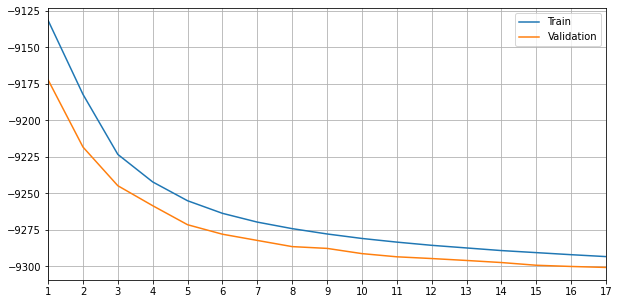

In [52]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(train_elbo)+1), train_elbo, label = "Train")
plt.plot(np.arange(1, len(val_elbo)+1), val_elbo, label = "Validation")
plt.legend()
plt.xticks(np.arange(1, len(train_elbo)+1))
plt.xlim(1, len(train_elbo))
plt.grid()
plt.show()

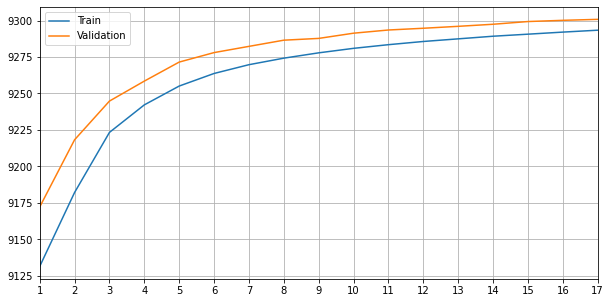

In [53]:
train_elbo = [i * -1 for i in train_elbo]
val_elbo = [i * -1 for i in val_elbo] 
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(train_elbo)+1), train_elbo, label = "Train")
plt.plot(np.arange(1, len(val_elbo)+1), val_elbo, label = "Validation")
plt.legend()
plt.xticks(np.arange(1, len(train_elbo)+1))
plt.xlim(1, len(train_elbo))
plt.grid()
plt.show()

In [54]:
original = train_x[:32]

# get the distribution paramters
_, (mu, log_sigma) = model.encoder(original.view(-1, 1, 28, 28))
epsilon = torch.randn_like(torch.exp(log_sigma)).to(device)
z = mu + torch.exp(log_sigma) * epsilon
alpha, beta = model.decoder(z)

variance = (alpha*beta)/((alpha+beta).pow(2)*(alpha+beta+1))
sample = alpha/(alpha+beta) + variance * torch.randn_like(variance)
sample = sample.view(-1, 28, 28).detach()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


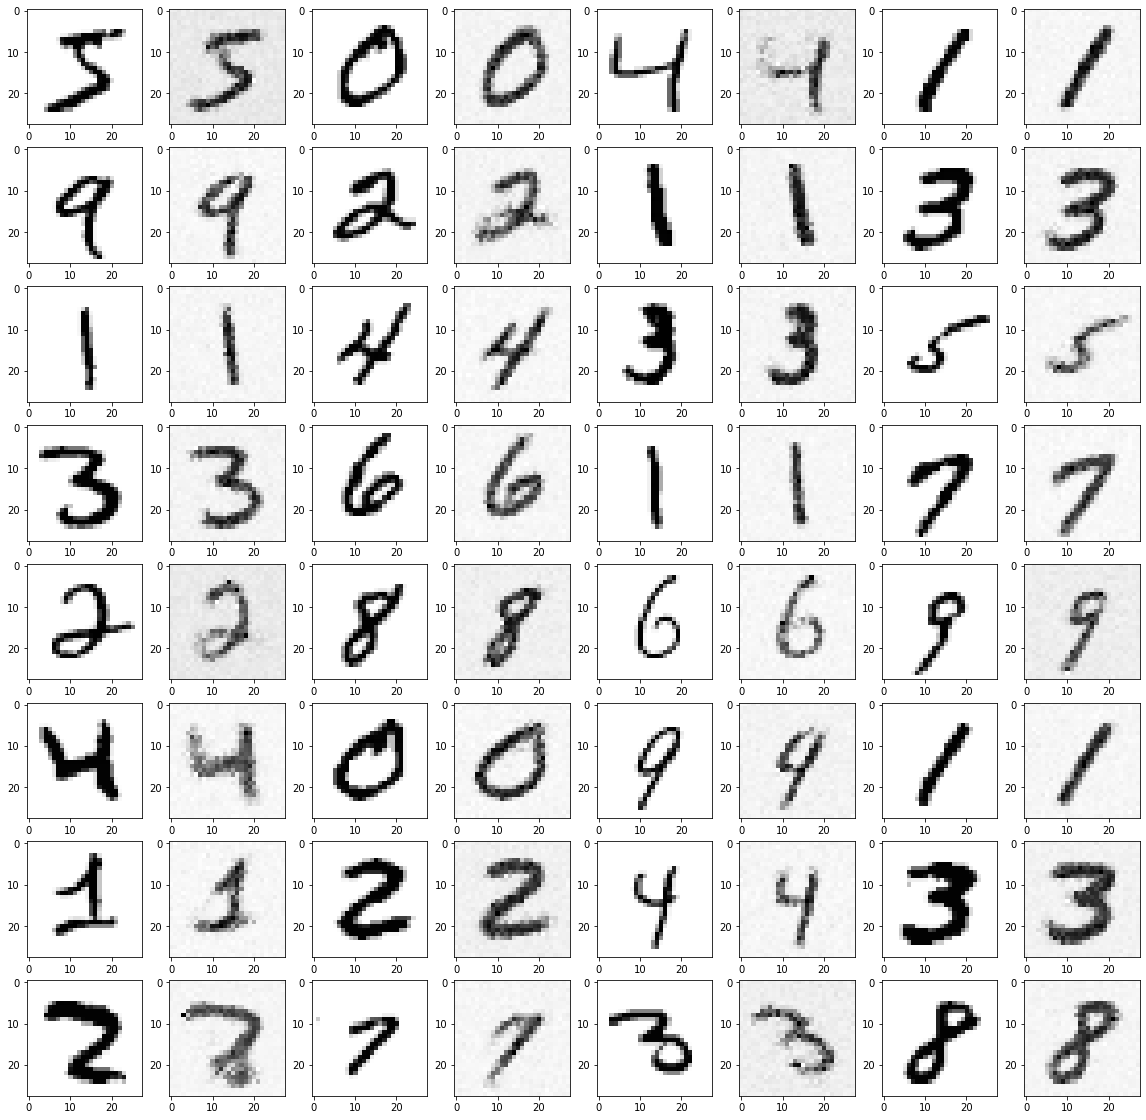

In [55]:
fig, ax = plt.subplots(8, 8, figsize=(20, 20))
for row in range(8):
    for column in np.arange(0, 8, 2):
        ax[row, column].imshow(original[row*4+int(column/2)].cpu().numpy(), cmap="Greys")
        ax[row, column+1].imshow(sample[row*4+int(column/2)].cpu().numpy(), cmap="Greys")
plt.show()

In [56]:
z = torch.randn(16, 16, device=device)
alpha, beta = model.decoder(z)
mu = alpha/(alpha+beta)
variance = (alpha*beta)/((alpha+beta).pow(2)*(alpha+beta+1))
sample = mu + variance * torch.randn_like(variance)
sample = sample.view(-1, 28, 28).detach()

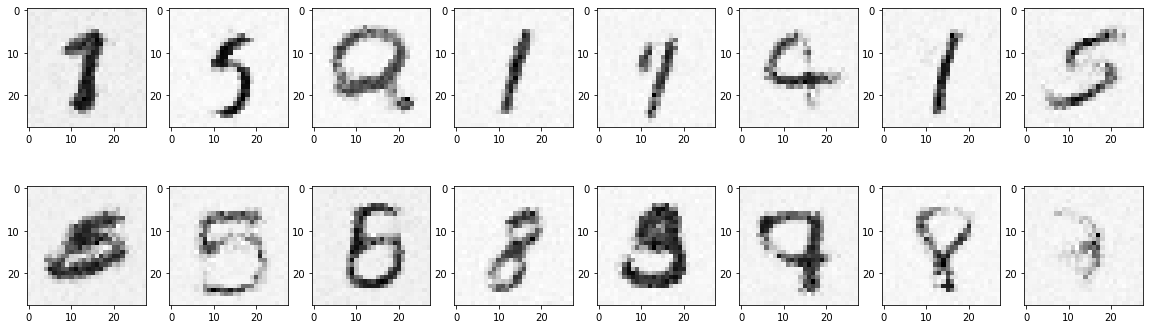

In [58]:
fig, ax = plt.subplots(2, 8, figsize=(20, 6))
for row in range(2):
    for column in range(8):
        ax[row, column].imshow(sample[row*8+column].cpu().numpy(), cmap="Greys")
plt.show()

In [59]:
torch.save(model, 'vae_beta.pt')

# 2c.Training and Testing for Categorical Distribution

\begin{align}
    \log p(\textbf{x}|\textbf{z}) &= \log \prod_{d=1}^D p(X_d|\textbf{z}) \\ 
    &= \sum_{d=1}^D log(Cat(X_d|\pi_d(\textbf{z})))
\\
    &= \sum_{d=1}^D log(P(X_d = k|\pi_d(\textbf{z})))
\\
\end{align}
In the decoder, we will output a pmf $\pi_d(z)$ for every pixels(totally 28*28 pmfs), each pmf consist of k probablities which is corresponding to k value.

In [60]:
class Categorical_Decoder(nn.Module):
    def __init__(self, k: int = 16, latent_dim: int = 16):
        super(Categorical_Decoder, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.k = k

        self.FC = nn.Linear(latent_dim, 3*3*128)
        # input: Nx128x3x3
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1) #Nx64x6x6
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=0, output_padding =1) #Nx32x14x14
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding = 1) #Nx1x28x28
        
        self.pmfs = nn.Linear(28*28, 28*28*k)

    def forward(self, x):
        h = F.leaky_relu(self.FC(x)).view(-1, 128, 3, 3)
        h = F.leaky_relu(self.deconv1(h))
        h = F.leaky_relu(self.deconv2(h))
        h = F.leaky_relu(self.deconv3(h))
        pmfs = F.softmax(self.pmfs(h.view(-1, 28*28)).view(-1, 28*28, self.k), dim=2)

        return pmfs

In [61]:
def loss_function(x, pmfs, mu, log_sigma):
      # log likelihood
      k = pmfs.shape[2]
      x_one_hot = F.one_hot(x.to(torch.int64), k)
      log_p = torch.sum(x_one_hot * torch.log(pmfs))
      # KL Divergence
      kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
      elbo = kl_loss - log_p
      return elbo, (log_p, kl_loss)

In [62]:
def train_model(model, train_x, val_x, loss_function, lr, epochs: int = 50, device = torch.device('cpu'), batch_size: int = 64, stopping_criterion = None):
    stopper = stopping_criterion

    elbo_train_values = []
    elbo_val_values = []
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    current_epoch = 0
    for epoch in range(epochs):
        model.train()
        overall_loss = 0
        shuffled_idx = torch.randperm(train_x.shape[0])
        idx_batches = shuffled_idx.split(batch_size)

        for batch_count, idx in enumerate(idx_batches):
            x = train_x[idx, :].to(device)

            optimizer.zero_grad()

            pmfs, mu, log_sigma = model(x.view(-1, 1, 28, 28)) 

            loss, _ = loss_function(x.view(x.shape[0], -1), pmfs, mu, log_sigma)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        n_datapoints = train_x.shape[0]
        elbo_train_values.append(overall_loss/n_datapoints)

        with torch.no_grad():
            val_loss = 0
            model.eval()
            shuffled_idx = torch.randperm(val_x.shape[0])
            idx_batches = shuffled_idx.split(batch_size)
            for batch_count, idx in enumerate(idx_batches):
                x = val_x[idx, :].to(device)

                pmfs, mu, log_sigma = model(x.view(-1, 1, 28, 28)) 

                loss, _ = loss_function(x.view(x.shape[0], -1), pmfs, mu, log_sigma)
                
                val_loss += loss.item()

            n_datapoints = val_x.shape[0]
            elbo_val_values.append(val_loss/n_datapoints)
        print("\tEpoch", epoch + 1, "\tTrain ELBO: ", elbo_train_values[-1], "\tValidation ELBO:",elbo_val_values[-1])
        
        if len(elbo_val_values) > 1:
            if stopper(elbo_val_values[-1], elbo_val_values[-2]):
                current_epoch = epoch
                print(f'STOPPING CRITERION: stopping criterion check satisfied after epoch {current_epoch}')
                break 
        current_epoch = epoch

    return elbo_train_values, elbo_val_values

In [63]:
number_pixels_per_bin = 5
k = int(255/number_pixels_per_bin) + 1
valid_x = torch.floor((train_dataset.data[-10000:, :]/number_pixels_per_bin).to(device))
train_x = torch.floor((train_dataset.data[:-10000, :]/number_pixels_per_bin).to(device))
test_x = torch.floor((test_dataset.data/number_pixels_per_bin).to(device))
print('Minimum (maximum) pixel value in batch: %d (%d)' % (train_x.min().item(), train_x.max().item()))

Minimum (maximum) pixel value in batch: 0 (51)


In [64]:
model = VAE(decoder = Categorical_Decoder(k = k))

stop_criterion = EarlyStopper(patience = 1, min_delta = 1)

train_elbo, val_elbo = train_model(model = model,
                                   train_x = train_x, 
                                   val_x = valid_x,
                                   loss_function= loss_function,
                                   lr = 1e-5,
                                   epochs = 30,
                                   device = device,
                                   batch_size = 64,
                                   stopping_criterion = stop_criterion)

	Epoch 1 	Train ELBO:  1279.03587203125 	Validation ELBO: 733.338402734375
	Epoch 2 	Train ELBO:  718.3587882226562 	Validation ELBO: 711.0271818359375
	Epoch 3 	Train ELBO:  707.5336676367187 	Validation ELBO: 706.2385657226563
	Epoch 4 	Train ELBO:  704.1504831445312 	Validation ELBO: 703.5738900390625
	Epoch 5 	Train ELBO:  701.9472640429688 	Validation ELBO: 701.7410630859375
	Epoch 6 	Train ELBO:  700.035871171875 	Validation ELBO: 699.6645435546875
	Epoch 7 	Train ELBO:  695.7635135742188 	Validation ELBO: 692.4765772460937
	Epoch 8 	Train ELBO:  688.2079351171875 	Validation ELBO: 686.5717603515625
	Epoch 9 	Train ELBO:  684.3087718945312 	Validation ELBO: 683.8116483398437
	Epoch 10 	Train ELBO:  681.8790604101563 	Validation ELBO: 681.4102219726562
	Epoch 11 	Train ELBO:  677.476972734375 	Validation ELBO: 673.1151938476562
	Epoch 12 	Train ELBO:  667.8644849609375 	Validation ELBO: 665.3902702148438
	Epoch 13 	Train ELBO:  662.5993630273438 	Validation ELBO: 661.1225114257812

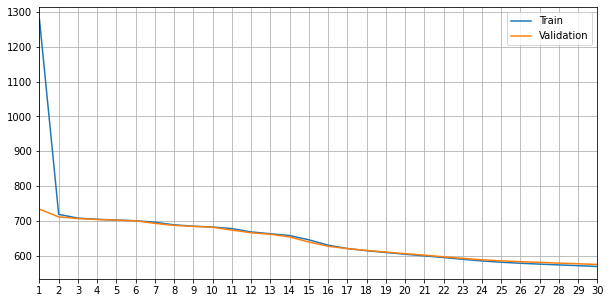

In [65]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(train_elbo)+1), train_elbo, label = "Train")
plt.plot(np.arange(1, len(val_elbo)+1), val_elbo, label = "Validation")
plt.legend()
plt.xticks(np.arange(1, len(train_elbo)+1))
plt.xlim(1, len(train_elbo))
plt.grid()
plt.show()

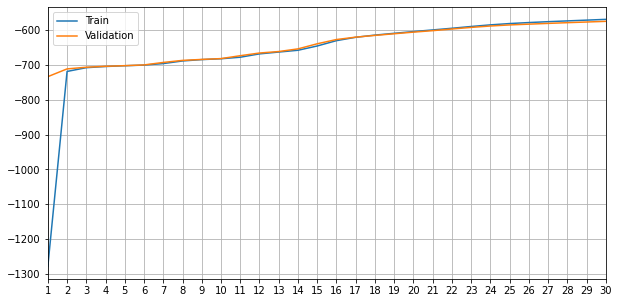

In [66]:
train_elbo = [i * -1 for i in train_elbo]
val_elbo = [i * -1 for i in val_elbo] 
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(train_elbo)+1), train_elbo, label = "Train")
plt.plot(np.arange(1, len(val_elbo)+1), val_elbo, label = "Validation")
plt.legend()
plt.xticks(np.arange(1, len(train_elbo)+1))
plt.xlim(1, len(train_elbo))
plt.grid()
plt.show()

In [67]:
original = train_x[:32]

# get the distribution paramters
_, (mu, log_sigma) = model.encoder(original.view(-1, 1, 28, 28))
epsilon = torch.randn_like(torch.exp(log_sigma)).to(device)
z = mu + torch.exp(log_sigma) * epsilon
pmfs = model.decoder(z)

from torch import distributions
# from distributions import Categorical
d = distributions.Categorical(pmfs)
# print(torch.tensor(sample))
sample = d.sample()/k
sample = sample.view(-1, 28, 28).detach()

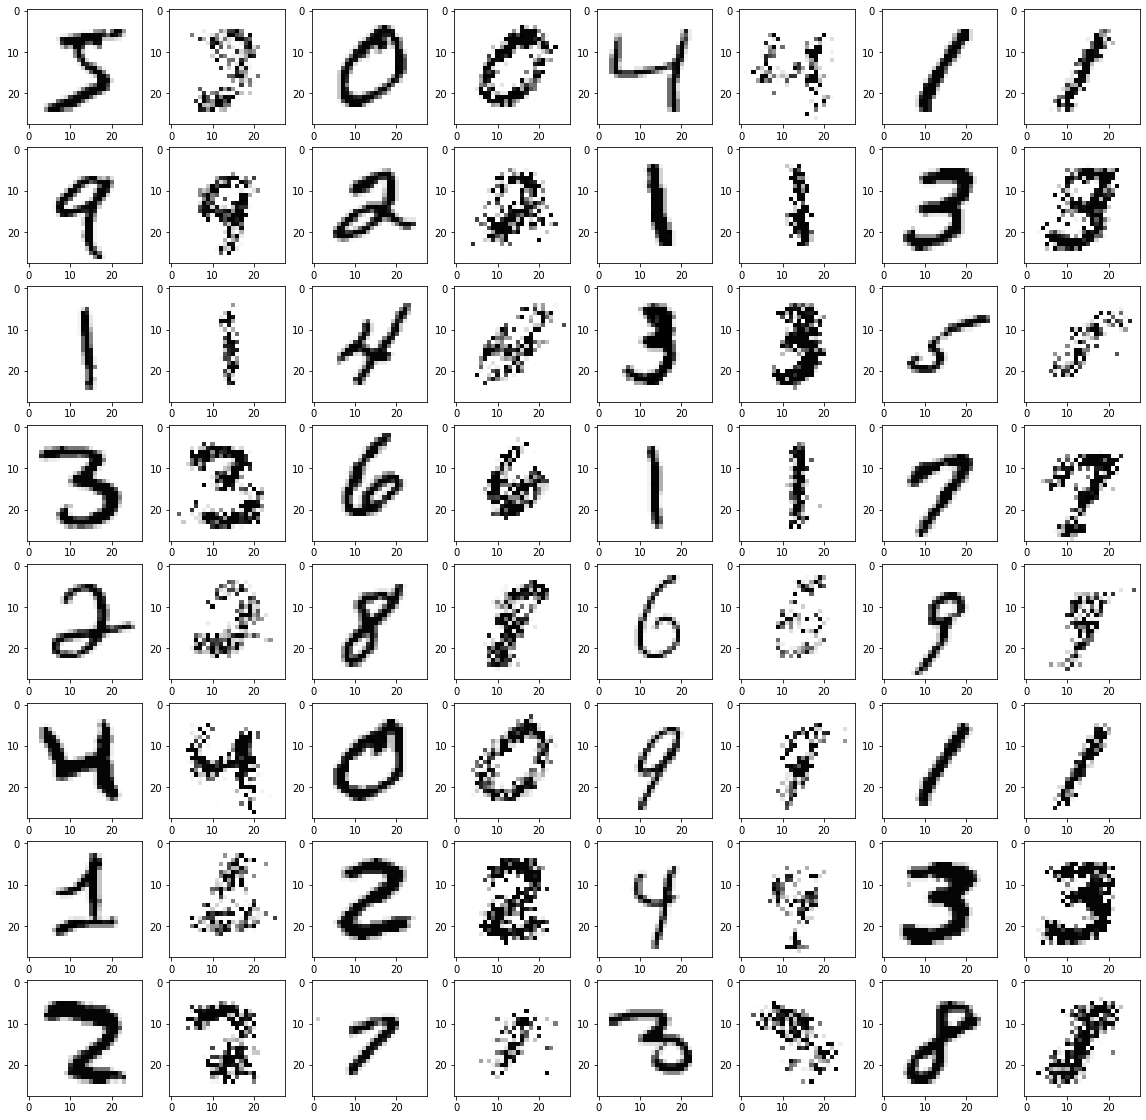

In [68]:
fig, ax = plt.subplots(8, 8, figsize=(20, 20))
for row in range(8):
    for column in np.arange(0, 8, 2):
        ax[row, column].imshow(original[row*4+int(column/2)].cpu().numpy(), cmap="Greys")
        ax[row, column+1].imshow(sample[row*4+int(column/2)].cpu().numpy(), cmap="Greys")
plt.show()

In [76]:
z = torch.randn(16, 16, device=device)
pmfs = model.decoder(z)
d = distributions.Categorical(pmfs)
d.sample()
sample = (d.sample() * 255/(k))/ 255
sample = sample.view(-1, 28, 28).detach()

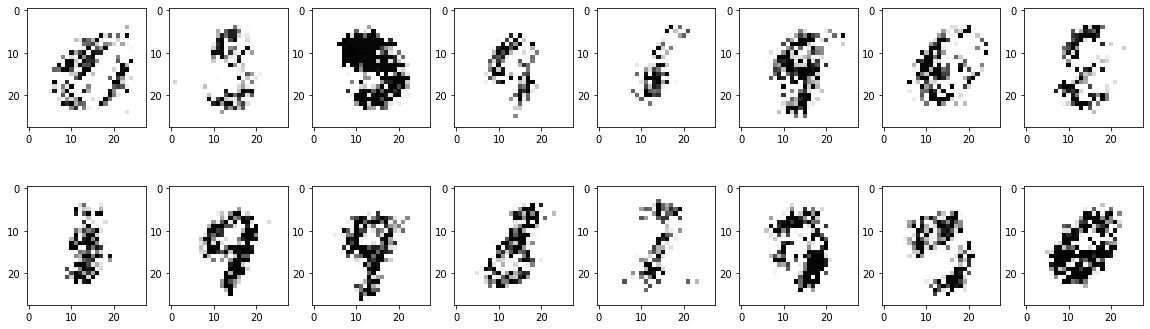

In [77]:
fig, ax = plt.subplots(2, 8, figsize=(20, 6))
for row in range(2):
    for column in range(8):
        ax[row, column].imshow(sample[row*8+column].cpu().numpy(), cmap="Greys")
plt.show()

In [78]:
torch.save(model, 'vae_categorical.pt')

# 2d.Training and Testing for Bernoulli Distribution

\begin{align}
    -H(p(\textbf{B}|\textbf{z}), p(\textbf{B}|\textbf{x})) &= E_{p(\textbf{B}|\textbf{z})}[logp(\textbf{b}|\textbf{z})]
\\
    &= \sum_{d=1}^Dx_dlog\pi_d(\textbf{z})+(1-x_d)log(1-\pi_d(\textbf{z}))
\\
\end{align}

In [33]:
class Bernoulli_Decoder(nn.Module):
    def __init__(self, latent_dim: int = 16):
        super(Bernoulli_Decoder, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.FC = nn.Linear(latent_dim, 3*3*128)
        # input: Nx128x3x3
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1) #Nx64x6x6
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=0, output_padding =1) #Nx32x14x14
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding = 1) #Nx1x28x28
        
        self.pmfs = nn.Linear(28*28, 28*28)

    def forward(self, x):
        h = F.leaky_relu(self.FC(x)).view(-1, 128, 3, 3)
        h = F.leaky_relu(self.deconv1(h))
        h = F.leaky_relu(self.deconv2(h))
        h = F.leaky_relu(self.deconv3(h))
        pmfs = F.sigmoid(self.pmfs(h.view(-1, 28*28)))

        return pmfs

In [34]:
def loss_function(x, pmfs, mu, log_sigma):
      # cross_entropy(log likelihood)
      cross_entropy = torch.sum(x*torch.log(pmfs)+(1-x)*torch.log(1-pmfs))
      # KL Divergence
      kl_loss = 0.5 * torch.sum(mu.pow(2) + (2*log_sigma).exp() - 2*log_sigma - 1)
      elbo = kl_loss - cross_entropy
      return elbo, (cross_entropy, kl_loss)

In [35]:
def train_model(model, train_x, val_x, loss_function, lr, epochs: int = 50, device = torch.device('cpu'), batch_size: int = 64, stopping_criterion = None):
    stopper = stopping_criterion

    elbo_train_values = []
    elbo_val_values = []
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    current_epoch = 0
    for epoch in range(epochs):
        model.train()
        overall_loss = 0
        shuffled_idx = torch.randperm(train_x.shape[0])
        idx_batches = shuffled_idx.split(batch_size)

        for batch_count, idx in enumerate(idx_batches):
            x = train_x[idx, :].to(device)

            optimizer.zero_grad()

            pmfs, mu, log_sigma = model(x.view(-1, 1, 28, 28)) 

            loss, _ = loss_function(x.view(x.shape[0], -1), pmfs, mu, log_sigma)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        n_datapoints = train_x.shape[0]
        elbo_train_values.append(overall_loss/n_datapoints)

        with torch.no_grad():
            val_loss = 0
            model.eval()
            shuffled_idx = torch.randperm(val_x.shape[0])
            idx_batches = shuffled_idx.split(batch_size)
            for batch_count, idx in enumerate(idx_batches):
                x = val_x[idx, :].to(device)

                pmfs, mu, log_sigma = model(x.view(-1, 1, 28, 28)) 

                loss, _ = loss_function(x.view(x.shape[0], -1), pmfs, mu, log_sigma)
                
                val_loss += loss.item()

            n_datapoints = val_x.shape[0]
            elbo_val_values.append(val_loss/n_datapoints)
        print("\tEpoch", epoch + 1, "\tTrain ELBO: ", elbo_train_values[-1], "\tValidation ELBO:",elbo_val_values[-1])
        
        if len(elbo_val_values) > 1:
            if stopper(elbo_val_values[-1], elbo_val_values[-2]):
                current_epoch = epoch
                print(f'STOPPING CRITERION: stopping criterion check satisfied after epoch {current_epoch}')
                break 
        current_epoch = epoch

    return elbo_train_values, elbo_val_values

In [36]:
valid_x = (train_dataset.data[-10000:, :]/255).to(device)
train_x = (train_dataset.data[:-10000, :]/255).to(device)
test_x = (test_dataset.data/255).to(device)

print('Minimum (maximum) pixel value in batch: %d (%d)' % (train_x.min().item(), train_x.max().item()))

Minimum (maximum) pixel value in batch: 0 (1)


In [38]:
model = VAE(Bernoulli_Decoder())

stop_criterion = EarlyStopper(patience = 1, min_delta = 1)

train_elbo, val_elbo = train_model(model = model,
                                   train_x = train_x, 
                                   val_x = valid_x,
                                   loss_function= loss_function,
                                   lr = 1e-4,
                                   epochs = 40,
                                   device = device,
                                   batch_size = 64,
                                   stopping_criterion = stop_criterion)

	Epoch 1 	Train ELBO:  219.8174998046875 	Validation ELBO: 193.51968393554688
	Epoch 2 	Train ELBO:  189.9315848388672 	Validation ELBO: 178.62514619140626
	Epoch 3 	Train ELBO:  165.338891171875 	Validation ELBO: 152.984858984375
	Epoch 4 	Train ELBO:  146.7790847167969 	Validation ELBO: 140.29835810546874
	Epoch 5 	Train ELBO:  136.44132923828124 	Validation ELBO: 132.67905083007813
	Epoch 6 	Train ELBO:  128.8946241015625 	Validation ELBO: 125.9003423095703
	Epoch 7 	Train ELBO:  123.29747444580079 	Validation ELBO: 121.40218603515625
	Epoch 8 	Train ELBO:  119.66607903808594 	Validation ELBO: 118.46635473632813
	Epoch 9 	Train ELBO:  117.01717576660157 	Validation ELBO: 116.05675601806641
	Epoch 10 	Train ELBO:  114.97536141601563 	Validation ELBO: 114.18438374023438
	Epoch 11 	Train ELBO:  113.46271602294922 	Validation ELBO: 112.85022021484374
	Epoch 12 	Train ELBO:  112.16090849609375 	Validation ELBO: 111.8275828125
	Epoch 13 	Train ELBO:  111.1555640234375 	Validation ELBO: 11

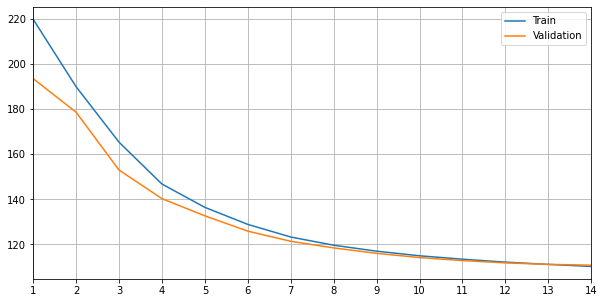

In [39]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(train_elbo)+1), train_elbo, label = "Train")
plt.plot(np.arange(1, len(val_elbo)+1), val_elbo, label = "Validation")
plt.legend()
plt.xticks(np.arange(1, len(train_elbo)+1))
plt.xlim(1, len(train_elbo))
plt.grid()
plt.show()

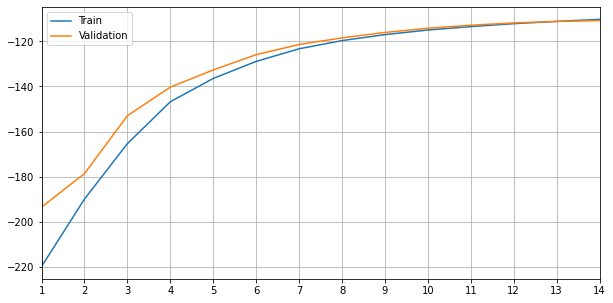

In [40]:
train_elbo = [i * -1 for i in train_elbo]
val_elbo = [i * -1 for i in val_elbo] 
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(train_elbo)+1), train_elbo, label = "Train")
plt.plot(np.arange(1, len(val_elbo)+1), val_elbo, label = "Validation")
plt.legend()
plt.xticks(np.arange(1, len(train_elbo)+1))
plt.xlim(1, len(train_elbo))
plt.grid()
plt.show()

In [41]:
original = train_x[:32]

# get the distribution paramters
_, (mu, log_sigma) = model.encoder(original.view(-1, 1, 28, 28))
epsilon = torch.randn_like(torch.exp(log_sigma)).to(device)
z = mu + torch.exp(log_sigma) * epsilon
pmfs = model.decoder(z)

# from torch import distributions
# d = distributions.Bernoulli(pmfs)
# sample = d.sample()
sample = pmfs.view(-1, 28, 28).detach()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


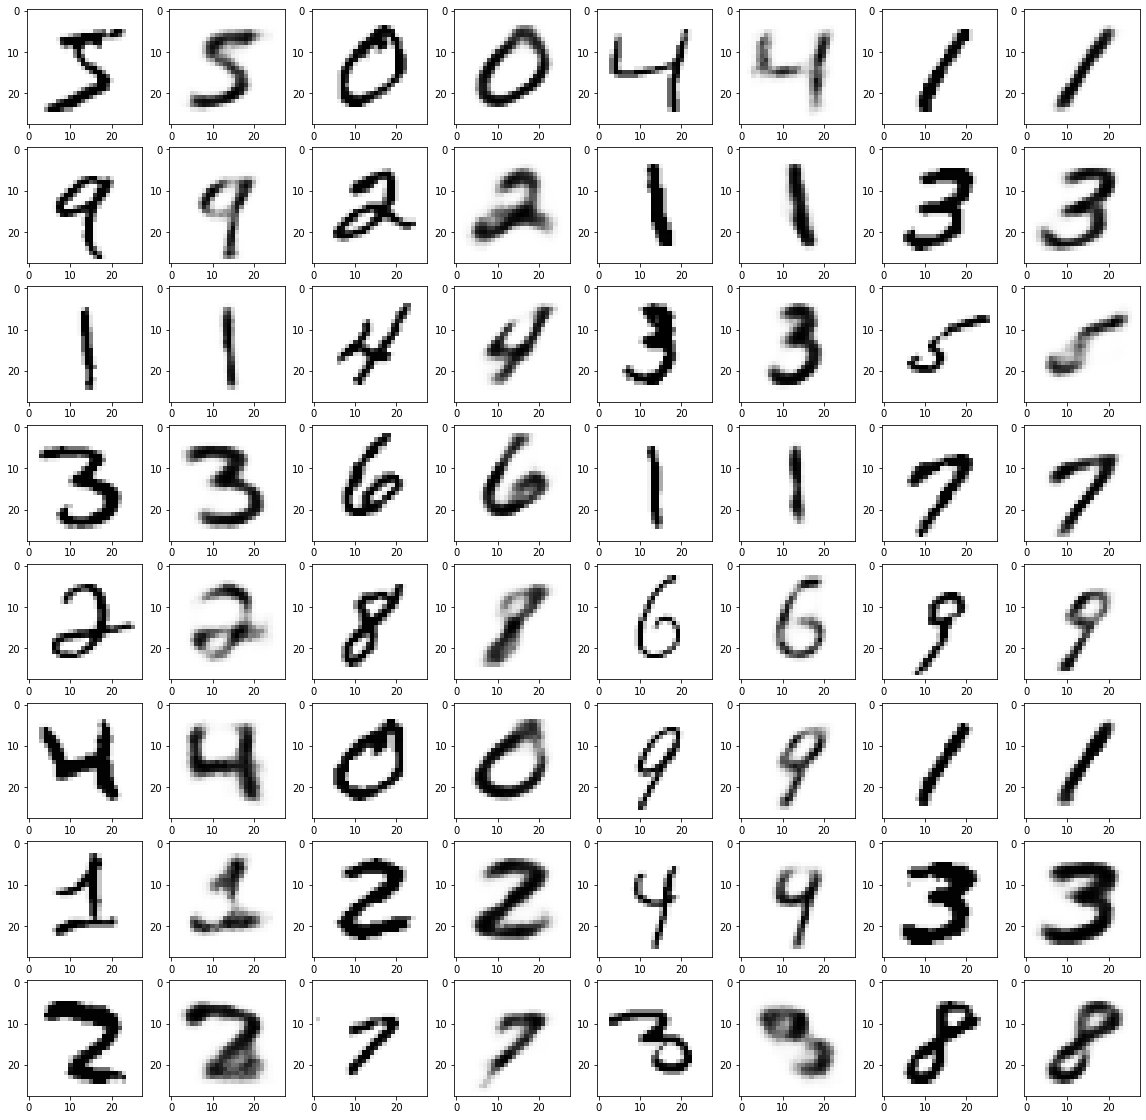

In [43]:
fig, ax = plt.subplots(8, 8, figsize=(20, 20))
for row in range(8):
    for column in np.arange(0, 8, 2):
        ax[row, column].imshow(original[row*4+int(column/2)].cpu().numpy(), cmap="Greys")
        ax[row, column+1].imshow(sample[row*4+int(column/2)].cpu().numpy(), cmap="Greys")
plt.show()

In [44]:
z = torch.randn(16, 16, device=device)
pmfs = model.decoder(z)
sample = pmfs.view(-1, 28, 28).detach()

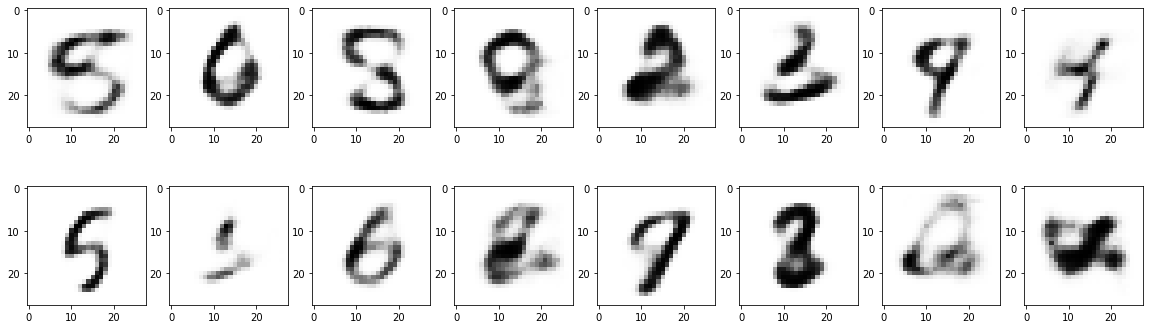

In [45]:
fig, ax = plt.subplots(2, 8, figsize=(20, 6))
for row in range(2):
    for column in range(8):
        ax[row, column].imshow(sample[row*8+column].cpu().numpy(), cmap="Greys")
plt.show()

In [46]:
torch.save(model, 'vae_bernoulli.pt')